In [1]:

import numpy as np
import torch
import torch.nn as nn
import importlib
import Model_Structure_pkg.Transformer_Model.model.transformer 

In [14]:
import importlib
import Model_Structure_pkg.Transformer_Model
import Model_Structure_pkg.Transformer_Model.model.decoder as decoder
import Model_Structure_pkg.Transformer_Model.model.encoder as encoder
import Model_Structure_pkg.Transformer_Model.model.transformer as transformer

# Reload all submodules in correct dependency order
importlib.reload(decoder)
importlib.reload(encoder)
importlib.reload(transformer)

from Model_Structure_pkg.Transformer_Model.model.transformer import Transformer
## Prepare some datasets as targets and inputs for the Transformer model
input_dim = 5  # Number of input features (e.g., channels)
trg_dim = 1    # Number of target features (e.g., PM2.5)
d_model = 64   # Dimension of the model (hidden size)
n_head = 8     # Number of attention heads
ffn_hidden = 256  # Dimension of the feed-forward network hidden layer
num_layers = 2  # Number of encoder/decoder layers
max_len = 40  # Maximum length of the input sequence
drop_prob = 0.1  # Dropout probability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = Transformer(input_dim, trg_dim, d_model, n_head, ffn_hidden, num_layers, max_len, drop_prob,device)

#prepare some input daata and target data batchs
batch_size = 16  # Number of samples in a batch
seq_length = 32  # Length of each input sequence
input_data = torch.randn(batch_size, seq_length, input_dim).to(device)  # Input data shape: (batch_size, seq_length, input_dim)
input_data = input_data + torch.Tensor(np.arange(seq_length)[:, np.newaxis]).to(device)  # Add a positional encoding
input_sum = torch.sum(input_data, dim=-1, keepdim=True)  # Sum over the last dimension

#Create a target_data tensor for learning, suitable for transformer
target_data = torch.Tensor(torch.square(input_sum)+0.32*input_sum+0.02).to(device)  # Target data shape: (batch_size, seq_length, trg_dim)

print('size of target_data:', target_data.size())
## select some random elements in target_data to nan values
nan_indices = np.random.choice(seq_length, size=int(seq_length * 0.1), replace=False)  # 10% of the target data will be NaN
target_data[:, nan_indices, :] = float('nan')  # Set selected indices to NaN

# Forward pass through the Transformer model
output = transformer_model(input_data, target_data)
# Output shape: (batch_size, seq_length, trg_dim)
print("Output shape:", output.shape)
# Check if the output shape matches the expected target shape
if output.shape == target_data.shape:
    print("Output shape matches target shape.")
else:
    print("Output shape does not match target shape.")



Transformer initialized with parameters:
Input Dimension: 5, Target Dimension: 1, d_model: 64, n_head: 8, ffn_hidden: 256, num_layers: 2, max_len: 40, drop_prob: 0.1
size of target_data: torch.Size([16, 32, 1])
Output shape: torch.Size([16, 32, 1])
Output shape matches target shape.


In [15]:


# Try to train a transformer model with the input and target data
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)  # Adam
# Training loop
num_epochs = 17  # Number of epochs for training
def r2_score(y_true, y_pred, mask):
    """
    Computes the R^2 score.
    """
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    ss_total = ((y_true - y_true.mean()) ** 2).sum()
    ss_residual = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_residual / ss_total)

def masked_mse_loss(predictions, targets, mask):
    """
    Computes the mean squared error loss with a mask.
    
    predictions: (B, T, D)
    targets:     (B, T, D)
    mask:        (B, T) or (B, T, 1) with 1 for valid, 0 for invalid
    """
    # Ensure mask is broadcastable
    if mask.dim() == 2:
        mask = mask.unsqueeze(-1)
    mask = mask.expand_as(targets).float()  # (B, T, D)
    squared_error = (predictions - targets) ** 2
    #print('squared_error:', squared_error, 'mask:', mask)  # Debugging shapes
    #print('predictions:', predictions)
    masked_loss = squared_error * mask
    #print('squared_error:', squared_error[0,:,:],'mask:', mask[0,:,:], 'masked_loss:', masked_loss[0,:,:])
    loss = masked_loss.sum() / mask.sum().clamp(min=1e-8)  # avoid divide by zero
    return loss

for epoch in range(num_epochs):
    transformer_model.train()  # Set the model to training mode

    optimizer.zero_grad()  # Zero the gradients
    output = transformer_model(input_data, target_data)  # Forward pass
    #print('output:', output)
    
    mask = ~torch.isnan(target_data)  # Create a mask for valid target data (not NaN)
    filled_target_data = torch.nan_to_num(target_data, nan=0.0)  # Fill NaN values in target data with 0.0
    loss = masked_mse_loss(output, filled_target_data, mask)  # Compute the loss
    
    print('Epoch:', epoch, 'Loss:', loss.item())
    loss.backward()  # Backward pass
    optimizer.step()  # Update the model parameters
    # Calculate the R2 of output and target
    r2 = r2_score(filled_target_data.detach().cpu().numpy(), output.detach().cpu().numpy(), mask.detach().cpu().numpy())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, R2: {r2:.4f}")  # Print the loss for each epoch

# Save the trained model
#torch.save(transformer_model.state_dict(), 'transformer_model.pth') 
# Load the trained model
#transformer_model.load_state_dict(torch.load('transformer_model.pth'))
transformer_model.eval()  # Set the model to evaluation mode
# Test the model with a new input

test_input = torch.randn(batch_size, seq_length, input_dim).to(device)  # New input data for testing
test_target = target_data = torch.sum(torch.square(test_input)+0.32*test_input+0.02, dim=-1).to(device).unsqueeze(-1)  # Target data shape: (batch_size, seq_length, trg_dim)
test_output = transformer_model(test_input)  # Forward pass with the test input
mask = ~torch.isnan(test_output)  # Create a mask for valid test output (not NaN)
r2 = r2_score(test_target.detach().cpu().numpy(), test_output.detach().cpu().numpy(), mask.detach().cpu().numpy())
print(f"Test R2 Score: {r2:.4f}")  # Print the R2 score for the test output

print("Test output shape:", test_output.shape)  # Output shape should be (batch_size, seq_length, trg_dim)
# Check if the test output shape matches the expected target shape
if test_output.shape == target_data.shape:
    print("Test output shape matches target shape.")
else:
    print("Test output shape does not match target shape.") 

Epoch: 0 Loss: 133438840.0
Epoch [1/17], Loss: 133438840.0000, R2: -1.3350
Epoch: 1 Loss: 133407512.0
Epoch [2/17], Loss: 133407512.0000, R2: -1.3344
Epoch: 2 Loss: 133389472.0
Epoch [3/17], Loss: 133389472.0000, R2: -1.3341
Epoch: 3 Loss: 133379440.0
Epoch [4/17], Loss: 133379440.0000, R2: -1.3339
Epoch: 4 Loss: 133373712.0
Epoch [5/17], Loss: 133373712.0000, R2: -1.3338
Epoch: 5 Loss: 133370168.0
Epoch [6/17], Loss: 133370168.0000, R2: -1.3338
Epoch: 6 Loss: 133367832.0
Epoch [7/17], Loss: 133367832.0000, R2: -1.3337
Epoch: 7 Loss: 133366112.0
Epoch [8/17], Loss: 133366112.0000, R2: -1.3337
Epoch: 8 Loss: 133364832.0
Epoch [9/17], Loss: 133364832.0000, R2: -1.3337
Epoch: 9 Loss: 133363592.0
Epoch [10/17], Loss: 133363592.0000, R2: -1.3337
Epoch: 10 Loss: 133362512.0
Epoch [11/17], Loss: 133362512.0000, R2: -1.3336
Epoch: 11 Loss: 133361256.0
Epoch [12/17], Loss: 133361256.0000, R2: -1.3336
Epoch: 12 Loss: 133360048.0
Epoch [13/17], Loss: 133360048.0000, R2: -1.3336
Epoch: 13 Loss: 13

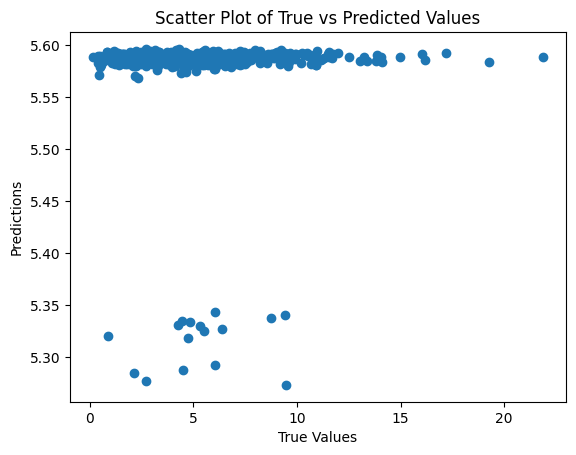

In [16]:
# print scatter for test points
import matplotlib.pyplot as plt

plt.scatter(test_target.detach().cpu().numpy(), test_output.detach().cpu().numpy())
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Scatter Plot of True vs Predicted Values")
plt.show()


In [ ]:
a = np.array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.9006e-02, 0.0000e+00, 0.0000e+00, 4.7595e-03,
         0.0000e+00, 0.0000e+00, 2.9945e-03, 0.0000e+00, 0.0000e+00, 2.2079e-02,
         0.0000e+00, 0.0000e+00, 5.1730e-05, 0.0000e+00, 0.0000e+00, 8.3892e-03,
         0.0000e+00, 0.0000e+00, 8.3657e-02, 0.0000e+00, 0.0000e+00, 9.9521e-03,
         0.0000e+00, 0.0000e+00, 1.2377e-03, 0.0000e+00, 0.0000e+00, 4.3398e-02,
         0.0000e+00])
mask = torch.Tensor([False, False, False, False, False, False, False, False,  True, False,
         False,  True, False, False,  True, False, False,  True, False, False,
          True, False, False,  True, False, False,  True, False, False,  True,
         False, False,  True, False, False,  True, False])

In [17]:
from Training_pkg.data_func import TransformerInputDatasets
from Training_pkg.TrainingModule import Transformer_train
from Training_pkg.utils import channel_names
import numpy as np
from Evaluation_pkg.data_func import randomly_select_training_testing_indices,Split_Datasets_based_site_index
from Model_Structure_pkg.Transformer_Model.model.transformer import Transformer
from Model_Structure_pkg.utils import Transformer_max_len, Transformer_spin_up_len
import numpy as np
import torch
import torch.nn as nn


print('Loading Transformer datasets...')
Init_CNN_Datasets = TransformerInputDatasets(species='PM25', total_channel_names=channel_names, bias=True, normalize_bias=True, normalize_species=False, absolute_species=False, datapoints_threshold=100)
total_sites_number = Init_CNN_Datasets.total_sites_number
true_input_mean, true_input_std = Init_CNN_Datasets.true_input_mean, Init_CNN_Datasets.true_input_std
TrainingDatasets_mean, TrainingDatasets_std = Init_CNN_Datasets.TrainingDatasets_mean, Init_CNN_Datasets.TrainingDatasets_std
sites_lat, sites_lon = Init_CNN_Datasets.sites_lat, Init_CNN_Datasets.sites_lon


Loading Transformer datasets...


ValueError: Observation file - The /my-projects2/Projects/Daily_PM25_DL_2024/data/GroundBased_Observations/AVD_d20240814/daily_PM25_data_20180101-20231231.npy file does not exist!